In [5]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

In [6]:
# Load the dataset
df = pd.read_csv("C:\\Users\\DELL\\Downloads\\aiops_logs.csv")
df.head()

# Display dataset information
df.info()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  4000 non-null   object
 1   level      4000 non-null   object
 2   message    4000 non-null   object
 3   label      4000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


timestamp    0
level        0
message      0
label        0
dtype: int64

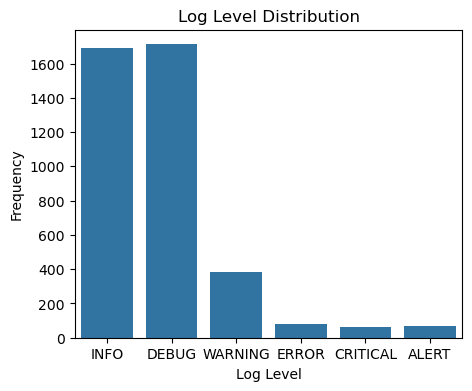

In [7]:
# Visualizing log level distribution
plt.figure(figsize=(5, 4))
sns.countplot(x=df['level'])
plt.title('Log Level Distribution')
plt.xlabel('Log Level')
plt.ylabel('Frequency')
plt.show()

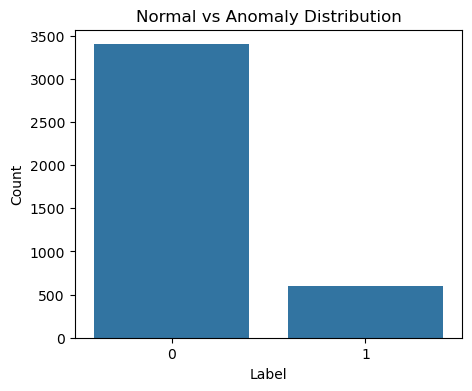

In [8]:
# Visualizing label distribution (normal vs anomaly)
plt.figure(figsize=(5, 4))
sns.countplot(x=df['label'])
plt.title('Normal vs Anomaly Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [9]:
# Preprocess and clean log messages
def clean_log(text):
    import re
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^a-zA-Z0-9 ]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip().lower()

df['clean_message'] = df['message'].apply(clean_log)
df.head()

,timestamp,level,message,label,clean_message
0,2024-01-01 00:00:00,INFO,Backup completed,0,backup completed
1,2024-01-01 00:00:04,DEBUG,Session token refreshed,0,session token refreshed
2,2024-01-01 00:00:02,DEBUG,Scheduled task executed,0,scheduled task executed
3,2024-01-01 00:00:15,DEBUG,Session token refreshed,0,session token refreshed
4,2024-01-01 00:00:08,INFO,Session token refreshed,0,session token refreshed


In [10]:
# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(df['clean_message'])

# Define target labels
y = df['label']

In [11]:
# Train Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X)

IsolationForest(contamination=0.05, random_state=42)

In [12]:
# Predict anomalies
df['predicted'] = model.predict(X)

In [13]:
# Convert predictions to human-readable labels
df['predicted'] = df['predicted'].replace({1: 'Normal', -1: 'Anomaly'})
df[['message', 'predicted']].head(20)

,message,predicted
0,Backup completed,Normal
1,Session token refreshed,Normal
2,Scheduled task executed,Normal
3,Session token refreshed,Normal
4,Session token refreshed,Normal
5,File uploaded,Normal
6,Configuration loaded,Normal
7,Backup completed,Normal
8,Cache hit for user session,Normal
9,Configuration loaded,Normal


In [14]:
# Evaluate the model (treat anomalies as "1")
true_labels = df['label']
pred_labels = df['predicted'].replace({'Normal': 0, 'Anomaly': 1})

In [15]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3401
           1       1.00      0.31      0.48       599

    accuracy                           0.90      4000
   macro avg       0.95      0.66      0.71      4000
weighted avg       0.91      0.90      0.87      4000

